In [1]:
"""
Starter code for the problem "Cart-pole swing-up".
Autonomous Systems Lab (ASL), Stanford University
"""
import time
from animations import animate_cartpole
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

r = 0.05
a = 0.05
b1 = 0.05
b2 = 0.05
b3 = 0.05
l1 = 0.3
l_cm1 = 0.2
I1 = 0.007
I2 = 0.07
tau1 = 1.0
tau2 = 1.0

def linearize(f, s, u):
    """Linearize the function `f(s, u)` around `(s, u)`.

    Arguments
    ---------
    f : callable
        A nonlinear function with call signature `f(s, u)`.
    s : numpy.ndarray
        The state (1-D).
    u : numpy.ndarray
        The control input (1-D).

    Returns
    -------
    A : numpy.ndarray
        The Jacobian of `f` at `(s, u)`, with respect to `s`.
    B : numpy.ndarray
        The Jacobian of `f` at `(s, u)`, with respect to `u`.
    """
    # WRITE YOUR CODE BELOW ###################################################
    # INSTRUCTIONS: Use JAX to compute `A` and `B` in one line.
    A, B = jax.jacfwd(f, argnums=0)(s, u), jax.jacfwd(f, argnums=1)(s, u)
    ###########################################################################
    return A, B

def ilqr(f, s0, s_goal, N, Q, R, QN, eps=1e-3, max_iters=1000):
    """Compute the iLQR set-point tracking solution.

    Arguments
    --------
    f : callable
        A function describing the discrete-time dynamics, such that
        `s[k+1] = f(s[k], u[k])`.
    s0 : numpy.ndarray
        The initial state (1-D).
    s_goal : numpy.ndarray
        The goal state (1-D).
    N : int
        The time horizon of the LQR cost function.
    Q : numpy.ndarray
        The state cost matrix (2-D).
    R : numpy.ndarray
        The control cost matrix (2-D).
    QN : numpy.ndarray
        The terminal state cost matrix (2-D).
    eps : float, optional
        Termination threshold for iLQR.
    max_iters : int, optional
        Maximum number of iLQR iterations.

    Returns
    -------
    s_bar : numpy.ndarray
        A 2-D array where `s_bar[k]` is the nominal state at time step `k`,
        for `k = 0, 1, ..., N-1`
    u_bar : numpy.ndarray
        A 2-D array where `u_bar[k]` is the nominal control at time step `k`,
        for `k = 0, 1, ..., N-1`
    Y : numpy.ndarray
        A 3-D array where `Y[k]` is the matrix gain term of the iLQR control
        law at time step `k`, for `k = 0, 1, ..., N-1`
    y : numpy.ndarray
        A 2-D array where `y[k]` is the offset term of the iLQR control law
        at time step `k`, for `k = 0, 1, ..., N-1`
    """
    if max_iters <= 1:
        raise ValueError("Argument `max_iters` must be at least 1.")
    
    n = Q.shape[0]  # state dimension
    m = R.shape[0]  # control dimension
    
    # Initialize gains `Y` and offsets `y` for the policy
    Y = np.zeros((N, m, n))
    y = np.zeros((N, m))
    
    # Initialize the nominal trajectory `(s_bar, u_bar)`, and the
    # deviations `(ds, du)`
    u_bar = np.zeros((N, m))
    s_bar = np.zeros((N + 1, n))
    s_bar[0] = s0
    for k in range(N):
        s_bar[k + 1] = f(s_bar[k], u_bar[k])
    
    ds = np.zeros((N + 1, n))
    du = np.zeros((N, m))
    
    # iLQR loop
    converged = False
    for _ in range(max_iters):
        # Linearize the dynamics at each step `k` of `(s_bar, u_bar)`
        A, B = jax.vmap(linearize, in_axes=(None, 0, 0))(f, s_bar[:-1], u_bar)
        A, B = np.array(A), np.array(B)
        
        # PART (c) ############################################################
        # INSTRUCTIONS: Update `Y`, `y`, `ds`, `du`, `s_bar`, and `u_bar`.
        V = QN 
        v = (s_bar[-1] - s_goal).T @ QN
        
        for k in range(N - 1, -1, -1):
            cx = Q @ (s_bar[k] - s_goal)
            cu = R @ u_bar[k]
            Qx = cx + A[k].T @ v
            Qu = cu + B[k].T @ v
            Qxx = Q + A[k].T @ V @ A[k]
            Quu = R + B[k].T @ V @ B[k]
            Qux = B[k].T @ V @ A[k]
            
            y[k] = -np.linalg.inv(Quu) @ Qu
            Y[k] = -np.linalg.inv(Quu) @ Qux
            V = Qxx - Y[k].T @ Quu @ Y[k]
            v = Qx - Y[k].T @ Quu @ y[k]
        
        s = np.zeros((N + 1, n))
        s[0] = s0
        u = np.zeros((N, m))
        
        for k in range(N):
            # Update Optimal Control
            ds[k] = s[k] - s_bar[k]
            du[k] = y[k] + Y[k] @ ds[k]
            u[k] = u_bar[k] + du[k]
            s[k + 1] = f(s[k], u[k])
        
        s_bar = np.copy(s)
        u_bar = np.copy(u)
        #######################################################################
        
        if np.max(np.abs(du)) < eps:
            converged = True
            break
    
    if not converged:
        raise RuntimeError("iLQR did not converge!")
    
    return s_bar, u_bar, Y, y

def cartpole(s, u):
    """Compute the cart-pole state derivative."""
    theta1, theta2, dtheta1, dtheta2 = s
    T1, T2, T3 = u
    ds = jnp.array([
        dtheta1,
        dtheta2,
        (1 / I1) * (T1 / r * (b1 * (np.sqrt(a**2 + b1**2) + l1 - l_cm1)) / np.sqrt(a**2 + b1**2) + tau1),
        (1 / I2) * (tau2 - T2 * b2 / r + T3 * b3 / r),
    ])
    return ds




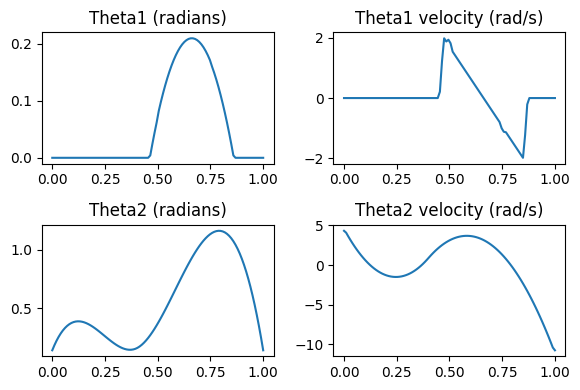

In [2]:
# Constants

n = 4  # state dimension
m = 3  # control dimension
R = 1e-1 * np.eye(m)  # control cost matrix
QN = 1e1 * np.eye(n)  # terminal state cost matrixeg
Q = np.diag([50, 50, 1, 1])
animate = False  # flag for animation
closed_loop = True  # flag for closed-loop control

mp = 2.0  # pendulum mass
mc = 10.0  # cart mass
L = 1.0  # pendulum length
g = 9.81  # gravitational acceleration
animate = False  # whether or not to animate results

import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

# Critical points for theta1
x_critical_theta1 = np.array([0, 0.14, 0.4, 0.72, 1])
y_critical_theta1 = np.array([8, 22, 9, 62, 8])

# Spline for theta1&theta2
cs_theta1 = CubicSpline(x_critical_theta1, y_critical_theta1)
x_range_theta1 = np.linspace(0, 1, 500)
y_spline_theta1 = cs_theta1(x_range_theta1)

x_spline_theta2 = np.array([0.63, 0.73, 0.83])
y_spline_theta2 = np.array([0, 12, 0])

cs_theta2 = CubicSpline(x_spline_theta2, y_spline_theta2)
x_range_theta2 = np.linspace(0.63, 0.83, 200)
y_spline_range_theta2 = cs_theta2(x_range_theta2)

num_const_before = 150
num_const_after = 150

x_full_theta2 = np.concatenate([np.linspace(0, 0.63, num_const_before), x_range_theta2, np.linspace(0.83, 1.0, num_const_after)])
y_full_theta2 = np.concatenate([np.zeros(num_const_before + 80), y_spline_range_theta2, np.zeros(num_const_after-80)])

total_time_steps = 100 
time_steps = np.linspace(0, 1, total_time_steps)

x_ref_full = np.zeros((total_time_steps, 4))
x_ref_full[:, 1] = cs_theta1(time_steps) * np.pi / 180  
x_ref_full[:, 0] = y_full_theta2[np.linspace(0, 499, total_time_steps, dtype=int)] * np.pi / 180  #
dt = 1.0 / total_time_steps  
x_ref_full[:, 2] = np.gradient(x_ref_full[:, 0], dt)  
x_ref_full[:, 3] = np.gradient(x_ref_full[:, 1], dt)  

# Plot the reference trajectories and their velocities
fig, axes = plt.subplots(2, 2, figsize=(6, 4))
axes[0, 0].plot(time_steps, x_ref_full[:, 0])
axes[0, 0].set_title('Theta1 (radians)')
axes[0, 1].plot(time_steps, x_ref_full[:, 2])
axes[0, 1].set_title('Theta1 velocity (rad/s)')
axes[1, 0].plot(time_steps, x_ref_full[:, 1])
axes[1, 0].set_title('Theta2 (radians)')
axes[1, 1].plot(time_steps, x_ref_full[:, 3])
axes[1, 1].set_title('Theta2 velocity (rad/s)')
plt.tight_layout()

In [3]:
# Initialize continuous-time and discretized dynamics
f = jax.jit(cartpole)
fd = jax.jit(lambda s, u: s + dt * f(s, u))

# Simulation parameters
T = 1.0
dt = 0.01
t = np.linspace(0, T, int(T / dt) + 1)
N = t.size - 1
total_time_steps = 100
time_steps = np.linspace(0, 1, total_time_steps)
closed_loop = True

# Initial state and reference trajectory
s0 = x_ref_full[0]  # Initial state is the first point of the reference trajectory
s_ref = x_ref_full

s = np.zeros((N + 1, n))
u = np.zeros((N, m))
s[0] = s0
total_cost = 0
# Loop over each time step to update control inputs using iLQR
for i in range(N):
    # Update reference for the current time step
    s_goal = s_ref[i] if i < len(s_ref) else s_ref[-1]

    # Compute the iLQR solution with the discretized dynamics
    print(f"Computing iLQR solution for time step {i} ... ", end="", flush=True)
    start = time.time()
    s_bar, u_bar, Y, y = ilqr(fd, s[i], s_goal, N - i, Q, R, QN)
    print(f"done! ({time.time() - start:.2f} s)", flush=True)

    # Simulate on the true continuous-time system
    print(f"Simulating for time step {i} ... ", end="", flush=True)
    start = time.time()
    if closed_loop:
        u[i] = u_bar[0] + y[0] + Y[0] @ (s[i] - s_bar[0])
    else:  # do open-loop control
        u[i] = u_bar[0]
    
    s[i + 1] = odeint(lambda s, t: f(s, u[i]), s[i], t[i:i + 2])[1]

    step_cost = (s[i] - s_goal).T @ Q @ (s[i] - s_goal) + u[i].T @ R @ u[i]
    total_cost += step_cost
    print(total_cost)
    print(f"done! ({time.time() - start:.2f} s)", flush=True)


Computing iLQR solution for time step 0 ... done! (2.06 s)
Simulating for time step 0 ... 14.589328878465722
done! (0.10 s)
Computing iLQR solution for time step 1 ... done! (0.90 s)
Simulating for time step 1 ... 22.244275269699187
done! (0.01 s)
Computing iLQR solution for time step 2 ... done! (0.89 s)
Simulating for time step 2 ... 29.958549515322535
done! (0.00 s)
Computing iLQR solution for time step 3 ... done! (0.50 s)
Simulating for time step 3 ... 37.00806352610311
done! (0.01 s)
Computing iLQR solution for time step 4 ... done! (0.70 s)
Simulating for time step 4 ... 42.567834484171456
done! (0.00 s)
Computing iLQR solution for time step 5 ... done! (0.46 s)
Simulating for time step 5 ... 46.52479868750957
done! (0.00 s)
Computing iLQR solution for time step 6 ... done! (0.50 s)
Simulating for time step 6 ... 49.17489183870164
done! (0.00 s)
Computing iLQR solution for time step 7 ... done! (0.55 s)
Simulating for time step 7 ... 50.93638952834474
done! (0.00 s)
Computing iL

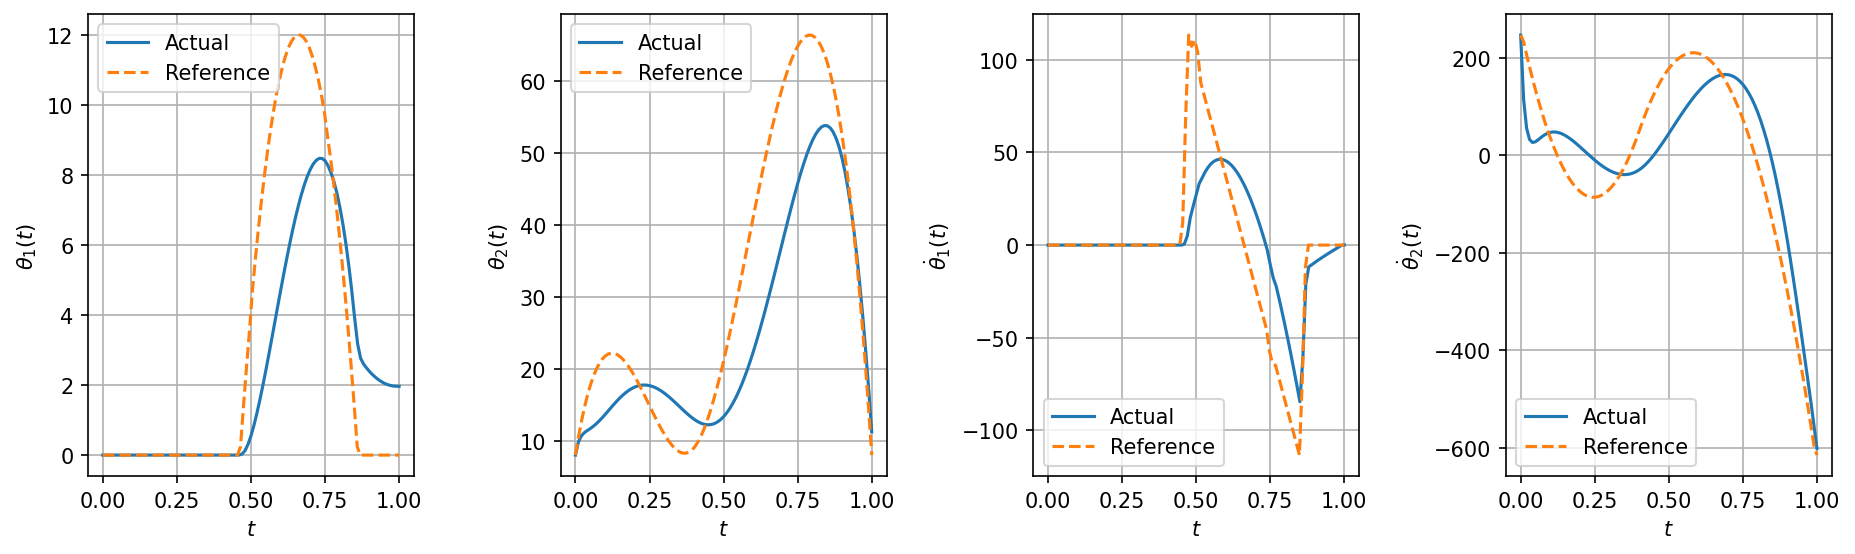

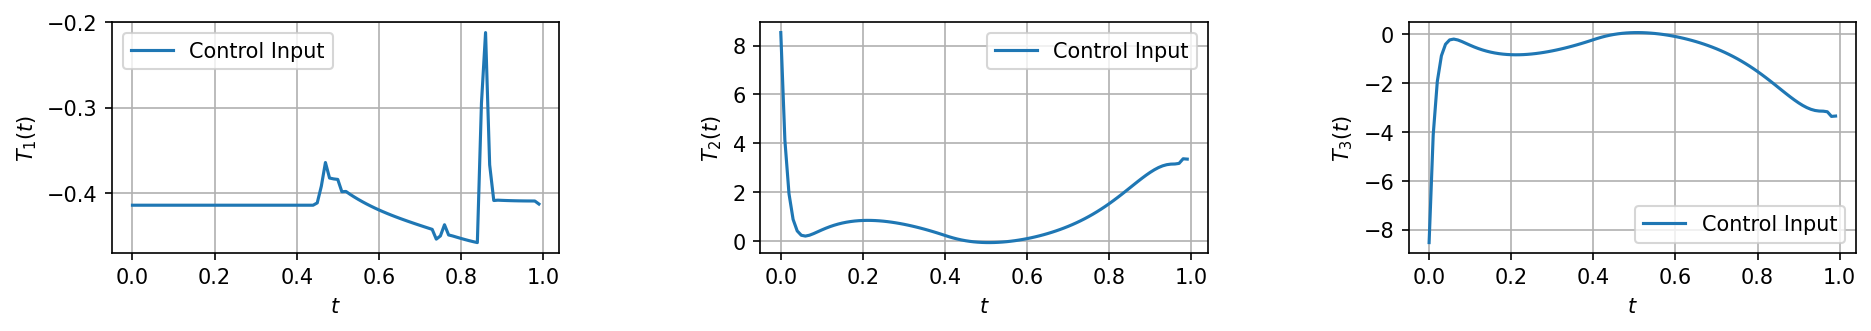

In [7]:
# Plot state trajectories
fig_states, axes_states = plt.subplots(1, n, dpi=150, figsize=(15, 4))
plt.subplots_adjust(wspace=0.45)
labels_s = (r"$\theta_1(t)$", r"$\theta_2(t)$", r"$\dot{\theta}_1(t)$", r"$\dot{\theta}_2(t)$")

s = s*180/np.pi
s_ref  = s_ref*180/np.pi

for i in range(n):
    axes_states[i].plot(t, s[:, i], label='Actual')
    axes_states[i].plot(time_steps, s_ref[:, i], "--", label='Reference')  # Adjust to match length of t
    axes_states[i].set_xlabel(r"$t$")
    axes_states[i].set_ylabel(labels_s[i])
    axes_states[i].legend()
    axes_states[i].grid(True)

# Save and show the state plot
fig_states.savefig("cartpole_swingup_states.png", bbox_inches="tight")

# Plot control trajectories
fig_controls, axes_controls = plt.subplots(1, m, dpi=150, figsize=(15, 2))
plt.subplots_adjust(wspace=0.45)
labels_u = (r"$T_1(t)$", r"$T_2(t)$", r"$T_3(t)$")

for i in range(m):
    axes_controls[i].plot(t[:-1], u[:, i], label='Control Input')
    axes_controls[i].set_xlabel(r"$t$")
    axes_controls[i].set_ylabel(labels_u[i])
    axes_controls[i].legend()
    axes_controls[i].grid(True)

# Save and show the control plot
fig_controls.savefig("cartpole_swingup_controls.png", bbox_inches="tight")

# Show plots
plt.show()
